<a href="https://colab.research.google.com/github/nikitakaraevv/fairness/blob/master/nbs/De_bias_face_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# De-biasing a face classifier

This work is largely inspired by [this MIT debiasing notebook](https://github.com/aamini/introtodeeplearning/blob/master/lab2/Part2_Debiasing.ipynb).
Here we will train a face classifier on an ImageNet / CelebA dataset and analyse its fairness.
Then we will use the method presented in [this article](https://lmrt.mit.edu/sites/default/files/AIES-19_paper_220.pdf) to de-bias our classifier.

The approach consists in applying a VAE to learn the latent space of face features. Then, faces with rare features (like glasses, hats, darker skin,...) will be sampled more often during training of a classifier.

## Imports

In [0]:
import matplotlib.pyplot as plt
import os
import cv2
import sys
import plotly.graph_objects as go
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F

ImageNet / CelebA datasets

In [0]:
!wget -q https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5

[PPB dataset](http://proceedings.mlr.press/v81/buolamwini18a/buolamwini18a.pdf) to check fairness of a model:

In [0]:
!wget -q https://www.dropbox.com/s/l0lp6qxeplumouf/PPB.tar;
!tar -xf PPB.tar;

In [2]:
!git clone https://github.com/nikitakaraevv/fairness.git

Cloning into 'fairness'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 1), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [0]:
from fairness.src import model
from fairness.src import utils
from fairness.src.dataset import FaceDetectionDataset, PPBdataset

## Face Classifier

In [0]:
tfs = transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             #std=[0.229, 0.224, 0.225])
    ])

### Exploring the dataset

In [0]:
train_dataset = FaceDetectionDataset("train_face.h5",
                                     transform=tfs)

In [0]:
number_of_training_examples = train_dataset.get_train_size()
batch = train_dataset.get_batch(100)
images, labels = batch['image'], batch['label']

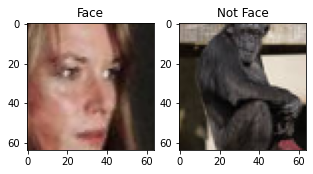

In [9]:
 ### Examining the CelebA training dataset ###

#@title Change the sliders to look at positive and negative training examples! { run: "auto" }

face_images = images[np.where(labels==1)[0]]
not_face_images = images[np.where(labels==0)[0]]

idx_face = 23 #@param {type:"slider", min:0, max:50, step:1}
idx_not_face = 33 #@param {type:"slider", min:0, max:50, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(transforms.ToPILImage()(face_images[idx_face]))
plt.title("Face"); plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(transforms.ToPILImage()(not_face_images[idx_not_face]))
plt.title("Not Face"); plt.grid(False)

### Training a classifier

In [0]:
num_epochs = 2  # keep small to run faster
learning_rate = 5e-4
batch_size = 32

classifier = model.get_classifier()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(),lr=learning_rate)

In [12]:
classifier.train()
for epoch in range(num_epochs):
    running_loss=0.
    for idx in tqdm(range(train_dataset.get_train_size()//batch_size)):
        # Grab a batch of training data and propagate through the network
        batch = train_dataset.get_batch(batch_size)
        input, labels = batch['image'], batch['label']
        
        output = classifier(input)

        optimizer.zero_grad()
        loss = criterion(output, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if idx % 100 == 99:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %3d / %3d], loss: %.3f' %
                    (epoch + 1,
                     idx + 1,
                     train_dataset.get_train_size()//batch_size,
                     running_loss / 100))
                running_loss = 0.0

        # Record the loss and plot the evolution of the loss as a function of training
        #loss_history.append(loss.item())
        #plotter.plot(loss_history.get())

[Epoch: 1, Batch: 100 / 3434], loss: 0.110
[Epoch: 1, Batch: 200 / 3434], loss: 0.037
[Epoch: 1, Batch: 300 / 3434], loss: 0.038
[Epoch: 1, Batch: 400 / 3434], loss: 0.028
[Epoch: 1, Batch: 500 / 3434], loss: 0.029
[Epoch: 1, Batch: 600 / 3434], loss: 0.031
[Epoch: 1, Batch: 700 / 3434], loss: 0.025
[Epoch: 1, Batch: 800 / 3434], loss: 0.029
[Epoch: 1, Batch: 900 / 3434], loss: 0.020
[Epoch: 1, Batch: 1000 / 3434], loss: 0.025
[Epoch: 1, Batch: 1100 / 3434], loss: 0.025
[Epoch: 1, Batch: 1200 / 3434], loss: 0.020
[Epoch: 1, Batch: 1300 / 3434], loss: 0.026
[Epoch: 1, Batch: 1400 / 3434], loss: 0.016
[Epoch: 1, Batch: 1500 / 3434], loss: 0.029
[Epoch: 1, Batch: 1600 / 3434], loss: 0.014
[Epoch: 1, Batch: 1700 / 3434], loss: 0.017
[Epoch: 1, Batch: 1800 / 3434], loss: 0.016
[Epoch: 1, Batch: 1900 / 3434], loss: 0.010
[Epoch: 1, Batch: 2000 / 3434], loss: 0.017
[Epoch: 1, Batch: 2100 / 3434], loss: 0.019
[Epoch: 1, Batch: 2200 / 3434], loss: 0.025
[Epoch: 1, Batch: 2300 / 3434], loss: 0.0

[Epoch: 2, Batch: 100 / 3434], loss: 0.010
[Epoch: 2, Batch: 200 / 3434], loss: 0.013
[Epoch: 2, Batch: 300 / 3434], loss: 0.027
[Epoch: 2, Batch: 400 / 3434], loss: 0.018
[Epoch: 2, Batch: 500 / 3434], loss: 0.011
[Epoch: 2, Batch: 600 / 3434], loss: 0.012
[Epoch: 2, Batch: 700 / 3434], loss: 0.013
[Epoch: 2, Batch: 800 / 3434], loss: 0.011
[Epoch: 2, Batch: 900 / 3434], loss: 0.006
[Epoch: 2, Batch: 1000 / 3434], loss: 0.007
[Epoch: 2, Batch: 1100 / 3434], loss: 0.011
[Epoch: 2, Batch: 1200 / 3434], loss: 0.014
[Epoch: 2, Batch: 1300 / 3434], loss: 0.008
[Epoch: 2, Batch: 1400 / 3434], loss: 0.014
[Epoch: 2, Batch: 1500 / 3434], loss: 0.006
[Epoch: 2, Batch: 1600 / 3434], loss: 0.018
[Epoch: 2, Batch: 1700 / 3434], loss: 0.007
[Epoch: 2, Batch: 1800 / 3434], loss: 0.011
[Epoch: 2, Batch: 1900 / 3434], loss: 0.016
[Epoch: 2, Batch: 2000 / 3434], loss: 0.015
[Epoch: 2, Batch: 2100 / 3434], loss: 0.005
[Epoch: 2, Batch: 2200 / 3434], loss: 0.008
[Epoch: 2, Batch: 2300 / 3434], loss: 0.0

In [0]:
PATH = '/ckpt.pth'
torch.save(classifier.state_dict(),
           PATH)

### Performance on the Train Dataset

In [0]:
classifier = model.get_classifier()
classifier.load_state_dict(torch.load(PATH))
classifier.eval();

In [16]:
total = 0
correct = 0
classifier.eval()
with torch.no_grad():
    for idx in tqdm(range(train_dataset.get_train_size()//batch_size)):
        batch = train_dataset.get_batch(batch_size)
        input, labels = batch['image'], batch['label']
        outputs = classifier(input)
        predicted = torch.round(nn.Sigmoid()(outputs))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#print(f"Accuracy of the network on test images: {100. * correct / total}")
print(f"Accuracy: {correct / total:.4f}")
print(f"Correct: {correct} / {total}")


Accuracy: 0.9964
Correct: 109493 / 109888


## PPB Dataset

In [0]:
ppb_root = os.path.join('/content', 'PPB-2017') #/content/drive/My Drive/
ppbdataset = PPBdataset(ppb_root)

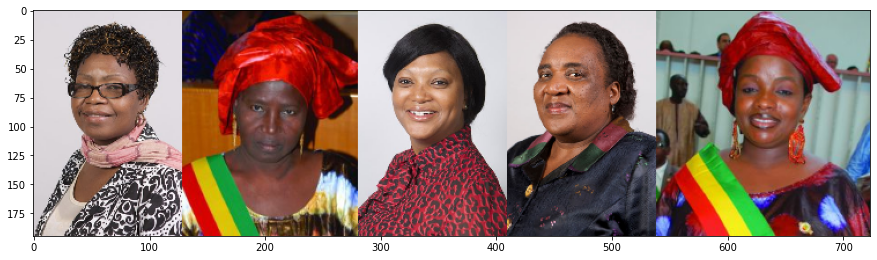

In [18]:
#@title { run: "auto" }

#ppb = raw_images # create the dataset handler

gender = "female" #@param ["male", "female"]
skin_color = "darker" #@param ["lighter", "darker"]
num = 5
group = ppbdataset.get_sample_faces_from_demographic(gender, skin_color, num=num)

plt.figure(figsize=(15,5))
plt.imshow(np.hstack(group))

## Fairness analysis
We will use [MTCNN Face Detector](https://github.com/timesler/facenet-pytorch) detector to crop faces from images in the PPB dataset. 

Cropped faces will be passed to the face classifier we've just trained.

But first of all, let's install it:

In [19]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 7.6MB/s 


In [0]:
from facenet_pytorch import MTCNN

In [0]:
mtcnn = MTCNN(image_size=224, select_largest = False, min_face_size=15, keep_all=True)

Let's test this detector on a random image from the PPB dataset:

In [0]:
arr = ppbdataset.raw_images['female_darker'][10]

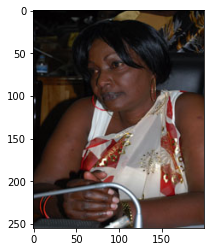

In [31]:
image = Image.fromarray(arr)#.resize((40, int(40 * arr.shape[0] / float(arr.shape[1])) ));
arr = np.array(image)
plt.imshow(image)

In [32]:
boxes, probs = mtcnn.detect(image)
if probs and probs[0]:
  print(f"MTCNN detector found a face on the image.")
  print(f"Its confidence is: {probs[0]:.5f}")

MTCNN detector found a face on the image.
Its confidence is: 0.99891


Let's crop the face with boxes provided by the detector:

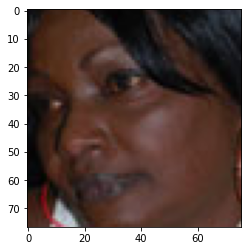

In [25]:
box = boxes.astype('int')[0]
center_horiz = int((box[2]+box[0]) / 2)
half_width = int((box[3]-box[1]) / 2)
left_edge = max(0, center_horiz-half_width)
right_edge = min(arr.shape[1], center_horiz+half_width)

arr_cropped = arr[box[1]:box[3], left_edge:right_edge]
image_cropped = Image.fromarray(arr_cropped);
plt.imshow(image_cropped)

In [26]:
our_pred = nn.Sigmoid()(classifier(tfs(image_cropped.resize((64,64))).unsqueeze(0))).item()
print(f"Confidence of our classifier: {our_pred:.4f}")

Confidence of our classifier: 0.1465


### Is MTCNN fair?

If MTCNN itself is not fair, it will add some bias to our experiment. Let's apply MTCNN to the PPB dataset and look at all the cropped faces to make sure that it will not affect the results of our experiment.

In [27]:
import collections
raw_images_face_sizes = collections.defaultdict(list)
# loop through all the groups
for key in tqdm(ppbdataset.raw_images.keys()):
    # loop through all the images of a group
    for i, arr in enumerate(ppbdataset.raw_images[key]):
        image = Image.fromarray(arr)
        boxes, probs = mtcnn.detect(image)
        # if no faces found, just skip it
        if probs[0] is not None:
            box = boxes.astype('int')[0]
            raw_images_face_sizes[key].append((arr, box))


We've just saved all the bounding boxes predicted by MTCNN.

For the further investigation, we can start by comparing the number of detected faces with the number of images of each  group:

In [33]:
for key in ppbdataset.raw_images:
    print(f"{key}: detected\
 {len(raw_images_face_sizes[key])} faces of {len(ppbdataset.raw_images[key])}")

male_darker: detected 317 faces of 318
male_lighter: detected 386 faces of 386
female_darker: detected 271 faces of 271
female_lighter: detected 295 faces of 295


One face in the group **male_darker** wasn't detected. So, MTCNN is probably biased.

Then we should manually check that all the faces are cropped correctly. For this, we repeatedly look at all the faces of the dataset cropped by MTCNN:

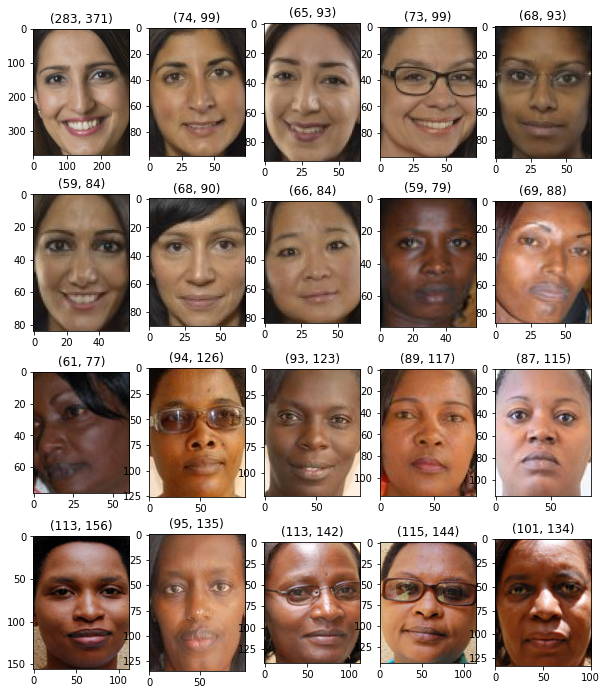

In [34]:
l = 20
# repeat it for different groups anf indices: 
fig, axs = plt.subplots(
    int(len(raw_images_face_sizes['female_darker'][0*l:l]) / 5.),
    5,
    figsize=(10,12) 
                        )
for i, (arr, box) in enumerate(raw_images_face_sizes['female_darker'][0*l:l]):
    im = Image.fromarray(arr[box[1]:box[3],
                             box[0]:box[2]])
    axs[ int(i/5), i%5].imshow(im)
    axs[ int(i/5), i%5].set_title(f"{im.size}")
    

Okay, it looks like all the faces for all the groups were cropped correctly. So, we can use MTCNN to crop faces that will be later passed to our trained classifier.

Then, let's see how the confidence of MTCNN varies depending on the size of the face to detect for all the 4 groups in the PPB dataset. 

For this, we will resize images in a way that **bounding boxes have the same height** for every image. It will allow us to see how MTCNN treats faces of different sizes.

In [0]:
face_sizes = range(10,28,2)

In [36]:
probs_dict = collections.defaultdict(dict)
# loop through all the face sizes
for new_face_size in tqdm(face_sizes):
    # loop through all the groups
    for key in raw_images_face_sizes:
        prob_cum = 0
        # loop through all the images of a group
        for arr, box in raw_images_face_sizes[key]:
            h, w, _ = arr.shape
            mult = new_face_size / float(box[3]-box[1])
            start_height =  h * mult 
            # height of an image can't be less than 25 pixels 
            new_height = max(int(start_height), 25)
            
            new_size = (new_height, int(new_height * h / float(w)))
            # resize the image
            image = Image.fromarray(arr).resize(new_size)
            _, probs = mtcnn.detect(image)
            # if no faces found, just skip it
            if probs[0] is not None:
                prob_cum+=probs[0]

        probs_dict[new_face_size][key] = prob_cum / float(len(raw_images_face_sizes[key]))


In [37]:
utils.plot_confidence(probs_dict)

Okay, **MTCNN itself is very biased**. 

Fortunately, since all the faces were cropped correctly, it will not affect the results of our further experiment.

### Fairness of the trained face classifier with the help of MTCNN

Here we will see how the accuracy of **our face detector** varies depending on the size of a face to classify for all the 4 groups in the PPB dataset. We will apply it to faces cropped by MTCNN. In this case, we **resize the faces themselves**, not the entire images.

In [0]:
face_sizes = [5,8,12,15,18,24,32,48,64]

In [0]:
def classifier_fairness(face_sizes, classifier, accuracy=True):
  probs_dict = collections.defaultdict(dict)
  # loop through all the face sizes
  for new_face_size in tqdm(face_sizes):
      # loop through all the groups
      for key in raw_images_face_sizes:
          prob_cum = 0.
          counter = 0.
          # loop through all the images of a group
          for arr, box in raw_images_face_sizes[key]:
              center_horiz = int((box[2]+box[0]) / 2)
              half_width = int((box[3]-box[1]) / 2)
              left_edge = max(0, center_horiz-half_width)
              right_edge = min(arr.shape[1], center_horiz+half_width)

              face = arr[box[1]:box[3], left_edge:right_edge]
              # resize the face
              face = Image.fromarray(face).resize((new_face_size,new_face_size))
              # Our classifier takes images of a size (64,64). 
              # So, resize back to (64,64)
              output = nn.Sigmoid()(classifier(tfs(face.resize((64,64))).unsqueeze(0)))
              # accuracy
              if accuracy:
                  output = torch.round(output)
              prob_cum+=output.item()
              counter+=1.

          probs_dict[new_face_size][key] = prob_cum / counter
  return probs_dict

In [55]:
probs_dict = classifier_fairness(face_sizes, classifier)

In [56]:
utils.plot_confidence(probs_dict)

## Create an unbiased classifier

In [0]:
# Hyperparameters
latent_dim=100
batch_size = 32
learning_rate = 5e-4

# DB-VAE needs slightly more epochs to train since its more complex than 
# the standard classifier so we use 6 instead of 2
num_epochs = 6  

num_encoder_dims = 2*latent_dim + 1
encoder = model.get_classifier(num_encoder_dims)
decoder = model.Decoder(latent_dim=latent_dim)

In [0]:
dbvae = model.DB_VAE(latent_dim)
optimizer = optim.Adam(dbvae.parameters(),
                       lr=learning_rate)

In [0]:
# get training faces from data loader
all_faces = train_dataset.get_all_train_faces()

In [40]:
all_faces.size()

torch.Size([54957, 3, 64, 64])

In [41]:
p_faces = model.get_training_sample_probabilities(all_faces, dbvae)

Recomputing the sampling probabilities


In [42]:
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

# The training loop -- outer loop iterates over the number of epochs
for epoch in range(num_epochs):
    
    # Recompute data sampling proabilities 
    p_faces = model.get_training_sample_probabilities(all_faces, dbvae)
    running_loss=0.
    for idx in tqdm(range(train_dataset.get_train_size() // batch_size)):
        # load a batch of data
        batch = train_dataset.get_batch(batch_size, p_pos=p_faces)
    
        input, labels = batch['image'], batch['label']
        y_logit, z_mean, z_logsigma, x_recon = dbvae(input)
    
        optimizer.zero_grad()
        loss, class_loss = model.debiasing_loss_function(input, x_recon, labels, y_logit, z_mean, z_logsigma)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if idx % 100 == 99:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %3d / %3d], loss: %.3f' %
                    (epoch + 1,
                     idx + 1,
                     train_dataset.get_train_size()//batch_size,
                     running_loss / 100))
                running_loss = 0.0
    
        #loss_history.append(loss.item())
        #plotter.plot(loss_history.get())



Recomputing the sampling probabilities


[Epoch: 1, Batch: 100 / 3434], loss: 9.667
[Epoch: 1, Batch: 200 / 3434], loss: 5.407
[Epoch: 1, Batch: 300 / 3434], loss: 4.792
[Epoch: 1, Batch: 400 / 3434], loss: 4.117
[Epoch: 1, Batch: 500 / 3434], loss: 4.338
[Epoch: 1, Batch: 600 / 3434], loss: 3.988
[Epoch: 1, Batch: 700 / 3434], loss: 3.783
[Epoch: 1, Batch: 800 / 3434], loss: 3.742
[Epoch: 1, Batch: 900 / 3434], loss: 3.648
[Epoch: 1, Batch: 1000 / 3434], loss: 3.388
[Epoch: 1, Batch: 1100 / 3434], loss: 3.385
[Epoch: 1, Batch: 1200 / 3434], loss: 3.126
[Epoch: 1, Batch: 1300 / 3434], loss: 3.383
[Epoch: 1, Batch: 1400 / 3434], loss: 3.206
[Epoch: 1, Batch: 1500 / 3434], loss: 2.884
[Epoch: 1, Batch: 1600 / 3434], loss: 2.975
[Epoch: 1, Batch: 1700 / 3434], loss: 2.566
[Epoch: 1, Batch: 1800 / 3434], loss: 2.862
[Epoch: 1, Batch: 1900 / 3434], loss: 2.864
[Epoch: 1, Batch: 2000 / 3434], loss: 3.088
[Epoch: 1, Batch: 2100 / 3434], loss: 2.779
[Epoch: 1, Batch: 2200 / 3434], loss: 2.738
[Epoch: 1, Batch: 2300 / 3434], loss: 2.7

[Epoch: 2, Batch: 100 / 3434], loss: 2.878
[Epoch: 2, Batch: 200 / 3434], loss: 2.559
[Epoch: 2, Batch: 300 / 3434], loss: 2.967
[Epoch: 2, Batch: 400 / 3434], loss: 2.407
[Epoch: 2, Batch: 500 / 3434], loss: 2.928
[Epoch: 2, Batch: 600 / 3434], loss: 2.509
[Epoch: 2, Batch: 700 / 3434], loss: 2.510
[Epoch: 2, Batch: 800 / 3434], loss: 2.406
[Epoch: 2, Batch: 900 / 3434], loss: 2.786
[Epoch: 2, Batch: 1000 / 3434], loss: 2.336
[Epoch: 2, Batch: 1100 / 3434], loss: 2.326
[Epoch: 2, Batch: 1200 / 3434], loss: 2.235
[Epoch: 2, Batch: 1300 / 3434], loss: 2.258
[Epoch: 2, Batch: 1400 / 3434], loss: 2.307
[Epoch: 2, Batch: 1500 / 3434], loss: 2.268
[Epoch: 2, Batch: 1600 / 3434], loss: 2.255
[Epoch: 2, Batch: 1700 / 3434], loss: 2.080
[Epoch: 2, Batch: 1800 / 3434], loss: 2.295
[Epoch: 2, Batch: 1900 / 3434], loss: 2.398
[Epoch: 2, Batch: 2000 / 3434], loss: 2.145
[Epoch: 2, Batch: 2100 / 3434], loss: 1.972
[Epoch: 2, Batch: 2200 / 3434], loss: 2.002
[Epoch: 2, Batch: 2300 / 3434], loss: 2.2

[Epoch: 3, Batch: 100 / 3434], loss: 1.999
[Epoch: 3, Batch: 200 / 3434], loss: 1.889
[Epoch: 3, Batch: 300 / 3434], loss: 1.953
[Epoch: 3, Batch: 400 / 3434], loss: 2.130
[Epoch: 3, Batch: 500 / 3434], loss: 2.092
[Epoch: 3, Batch: 600 / 3434], loss: 1.911
[Epoch: 3, Batch: 700 / 3434], loss: 1.903
[Epoch: 3, Batch: 800 / 3434], loss: 2.000
[Epoch: 3, Batch: 900 / 3434], loss: 2.074
[Epoch: 3, Batch: 1000 / 3434], loss: 1.853
[Epoch: 3, Batch: 1100 / 3434], loss: 2.078
[Epoch: 3, Batch: 1200 / 3434], loss: 2.137
[Epoch: 3, Batch: 1300 / 3434], loss: 2.133
[Epoch: 3, Batch: 1400 / 3434], loss: 1.843
[Epoch: 3, Batch: 1500 / 3434], loss: 1.973
[Epoch: 3, Batch: 1600 / 3434], loss: 1.782
[Epoch: 3, Batch: 1700 / 3434], loss: 1.933
[Epoch: 3, Batch: 1800 / 3434], loss: 2.106
[Epoch: 3, Batch: 1900 / 3434], loss: 2.058
[Epoch: 3, Batch: 2000 / 3434], loss: 1.799
[Epoch: 3, Batch: 2100 / 3434], loss: 1.823
[Epoch: 3, Batch: 2200 / 3434], loss: 1.869
[Epoch: 3, Batch: 2300 / 3434], loss: 1.7

[Epoch: 4, Batch: 100 / 3434], loss: 1.947
[Epoch: 4, Batch: 200 / 3434], loss: 2.030
[Epoch: 4, Batch: 300 / 3434], loss: 1.935
[Epoch: 4, Batch: 400 / 3434], loss: 1.916
[Epoch: 4, Batch: 500 / 3434], loss: 1.719
[Epoch: 4, Batch: 600 / 3434], loss: 1.789
[Epoch: 4, Batch: 700 / 3434], loss: 1.816
[Epoch: 4, Batch: 800 / 3434], loss: 1.959
[Epoch: 4, Batch: 900 / 3434], loss: 1.780
[Epoch: 4, Batch: 1000 / 3434], loss: 1.838
[Epoch: 4, Batch: 1100 / 3434], loss: 1.712
[Epoch: 4, Batch: 1200 / 3434], loss: 1.918
[Epoch: 4, Batch: 1300 / 3434], loss: 1.954
[Epoch: 4, Batch: 1400 / 3434], loss: 1.910
[Epoch: 4, Batch: 1500 / 3434], loss: 1.993
[Epoch: 4, Batch: 1600 / 3434], loss: 1.744
[Epoch: 4, Batch: 1700 / 3434], loss: 1.795
[Epoch: 4, Batch: 1800 / 3434], loss: 1.766
[Epoch: 4, Batch: 1900 / 3434], loss: 1.692
[Epoch: 4, Batch: 2000 / 3434], loss: 1.696
[Epoch: 4, Batch: 2100 / 3434], loss: 1.815
[Epoch: 4, Batch: 2200 / 3434], loss: 1.812
[Epoch: 4, Batch: 2300 / 3434], loss: 1.9

[Epoch: 5, Batch: 100 / 3434], loss: 1.733
[Epoch: 5, Batch: 200 / 3434], loss: 1.729
[Epoch: 5, Batch: 300 / 3434], loss: 1.800
[Epoch: 5, Batch: 400 / 3434], loss: 1.756
[Epoch: 5, Batch: 500 / 3434], loss: 1.794
[Epoch: 5, Batch: 600 / 3434], loss: 1.736
[Epoch: 5, Batch: 700 / 3434], loss: 1.725
[Epoch: 5, Batch: 800 / 3434], loss: 1.790
[Epoch: 5, Batch: 900 / 3434], loss: 1.740
[Epoch: 5, Batch: 1000 / 3434], loss: 1.691
[Epoch: 5, Batch: 1100 / 3434], loss: 1.679
[Epoch: 5, Batch: 1200 / 3434], loss: 1.680
[Epoch: 5, Batch: 1300 / 3434], loss: 1.802
[Epoch: 5, Batch: 1400 / 3434], loss: 1.752
[Epoch: 5, Batch: 1500 / 3434], loss: 1.784
[Epoch: 5, Batch: 1600 / 3434], loss: 1.797
[Epoch: 5, Batch: 1700 / 3434], loss: 1.716
[Epoch: 5, Batch: 1800 / 3434], loss: 1.769
[Epoch: 5, Batch: 1900 / 3434], loss: 1.733
[Epoch: 5, Batch: 2000 / 3434], loss: 1.686
[Epoch: 5, Batch: 2100 / 3434], loss: 1.743
[Epoch: 5, Batch: 2200 / 3434], loss: 1.695
[Epoch: 5, Batch: 2300 / 3434], loss: 1.8

[Epoch: 6, Batch: 100 / 3434], loss: 1.830
[Epoch: 6, Batch: 200 / 3434], loss: 1.793
[Epoch: 6, Batch: 300 / 3434], loss: 1.817
[Epoch: 6, Batch: 400 / 3434], loss: 1.714
[Epoch: 6, Batch: 500 / 3434], loss: 1.631
[Epoch: 6, Batch: 600 / 3434], loss: 1.594
[Epoch: 6, Batch: 700 / 3434], loss: 1.711
[Epoch: 6, Batch: 800 / 3434], loss: 1.703
[Epoch: 6, Batch: 900 / 3434], loss: 1.598
[Epoch: 6, Batch: 1000 / 3434], loss: 1.615
[Epoch: 6, Batch: 1100 / 3434], loss: 1.612
[Epoch: 6, Batch: 1200 / 3434], loss: 1.628
[Epoch: 6, Batch: 1300 / 3434], loss: 1.663
[Epoch: 6, Batch: 1400 / 3434], loss: 1.582
[Epoch: 6, Batch: 1500 / 3434], loss: 1.612
[Epoch: 6, Batch: 1600 / 3434], loss: 1.618
[Epoch: 6, Batch: 1700 / 3434], loss: 1.594
[Epoch: 6, Batch: 1800 / 3434], loss: 1.624
[Epoch: 6, Batch: 1900 / 3434], loss: 1.659
[Epoch: 6, Batch: 2000 / 3434], loss: 1.579
[Epoch: 6, Batch: 2100 / 3434], loss: 1.604
[Epoch: 6, Batch: 2200 / 3434], loss: 1.674
[Epoch: 6, Batch: 2300 / 3434], loss: 1.7

Distribution of sampling probabilities:

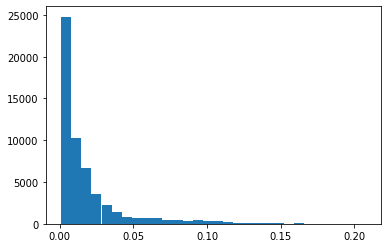

In [53]:
 plt.hist(p_faces*1000, bins=30);  # probability divided by 1000

In [0]:
most_prob_faces = train_dataset.get_n_most_prob_faces(p_faces, 10)
least_prob_faces = train_dataset.get_n_least_prob_faces(p_faces, 10)

In [0]:
def plot_faces(arr):
  fig, axs = plt.subplots(2,10, figsize=(15,4) )
  for i, im in enumerate(arr):
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#(im*255).astype('uint8'))
      axs[0][i].imshow(im.astype('uint8'))
      _, _, _, recon = dbvae(tfs(im).unsqueeze(0))
      recon = Image.fromarray((nn.Sigmoid()(recon)[0].detach().numpy().transpose(1,2,0)*255).astype('uint8'))
      axs[1][i].imshow(recon)

Looking at the most probable and least probable faces to be sampled, we can make sure that the learned latent space  indeed captures the data distribution:

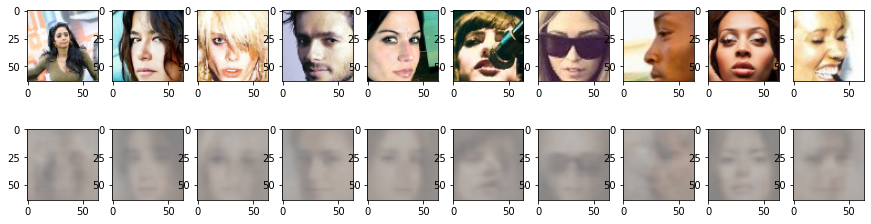

In [51]:
plot_faces(most_prob_faces)

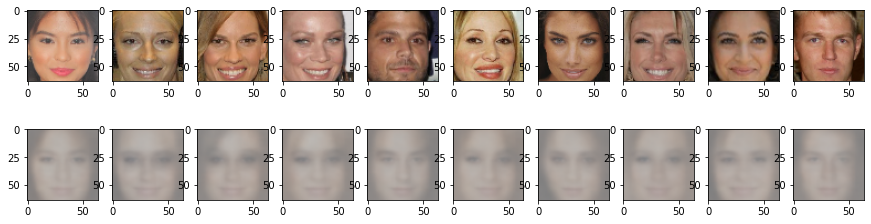

In [52]:
plot_faces(least_prob_faces)

In [0]:
face_sizes=[5,8,12,15,18,24,32,48,64]

In [49]:
probs_dict = classifier_fairness(face_sizes, dbvae.predict)

In [54]:
utils.plot_confidence(probs_dict)

We can notice that even though the difference in accuracy among all the groups has decreased, **the classifier is still biased**. So, there is still a lot to do in order to make face detectors more fair.

Moreover, in this notebook de-biasing was applied to a face classifier, but the same approach can be used to de-bias face detectors. 